# Synthetic data

This notebook is to generate synthetic data for NN learning.

Goal is to do it like **"Transfer learning of recurrent neural network-based
plasticity models"**

## 1. Random walks of $\epsilon$

In [2]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def build_path(array):
    num_vectors = array.shape[0]
    visited = np.zeros(num_vectors, dtype=bool)
    path = np.zeros_like(array)

    for i in range(num_vectors):
        if i == 0:
            current_vector = array[i]
        else:
            distances = cdist(array, np.array([current_vector]))
            distances[visited] = np.inf
            next_index = np.argmin(distances)
            current_vector = array[next_index]
            visited[next_index] = True

        path[i] = current_vector

    return path

def insert_vectors_between_(vectors, k):
    result = []
    for i in range(len(vectors) - 1):
        current_vector = vectors[i]
        next_vector = vectors[i + 1]

        # Линейно интерполируем координаты между текущим и следующим вектором
        interpolated_vectors = [current_vector + (j / (k + 1)) * (next_vector - current_vector) for j in range(1, k + 1)]

        # Добавляем текущий вектор и интерполированные векторы в результат
        result.extend([current_vector] + interpolated_vectors)

    # Добавляем последний вектор в результат
    result.append(vectors[-1])

    return np.array(result)

def insert_vectors_between(vectors, k, sigm):
    result = []
    for i in range(len(vectors) - 1):
        current_vector = vectors[i]
        next_vector = vectors[i + 1]

        # Линейно интерполируем координаты между текущим и следующим вектором
        interpolated_vectors = [current_vector + (j / (k + 1)) * (next_vector - current_vector) for j in range(1, k + 1)]

        # Добавляем шум с нормальным распределением к каждой координате интерполированных векторов
        noise = np.random.normal(scale=sigm, size=(k, len(current_vector)))
        interpolated_vectors_with_noise = [vec + noise[i].tolist() for i, vec in enumerate(interpolated_vectors)]

        # Добавляем текущий вектор и интерполированные векторы с шумом в результат
        result.extend([current_vector] + interpolated_vectors_with_noise)

    # Добавляем последний вектор в результат
    result.append(vectors[-1])

    return np.array(result)

def generate_random_sequence(dim, threshold, num_points, start_point=None):
    points = [] if start_point is None else [start_point]
    
    for _ in range(num_points):
        if not points:
            # Генерируем первый вектор случайным образом
            point = np.zeros(dim)#random.uniform(low=-threshold, high=threshold, size=dim)
        else:
            # Генерируем следующий вектор
            direction = np.random.uniform(low=-1, high=1, size=dim)
            direction /= np.linalg.norm(direction)
            magnitude = np.random.uniform(low=1e-3, high=1e-1)
            point = points[-1] + magnitude * direction

            # Проверяем, не превышает ли норма вектора threshold
            while np.linalg.norm(point) > threshold:
                direction = np.random.uniform(low=-1, high=1, size=dim)
                direction /= np.linalg.norm(direction)
                magnitude = np.random.uniform(low=0.002, high=0.01)
                point = points[-1] + magnitude * direction
                # print(np.linalg.norm(point))

        points.append(point)

    result = []
    for i in range(len(points) - 1):
        # Вычисляем количество промежуточных точек для интерполяции
        k = int(np.linalg.norm(points[i + 1] - points[i]) / (np.sqrt(3 / 2) * 1e-2))
        # print(k)
        
        # Линейная интерполяция между точками
        interpolated_vectors = [
            points[i] + (j / (k + 1)) * (points[i + 1] - points[i]) for j in range(1, k + 1)
        ]

        # Накладываем шум
        for idx in range(len(interpolated_vectors)):
            direction = points[i + 1] - points[i]
            noise_magnitude = np.random.uniform(low=0.002, high=0.01)
            noise_direction = np.random.uniform(low=-1, high=1, size=dim)
            noise_direction /= np.linalg.norm(noise_direction)
            noise = noise_magnitude * noise_direction
            interpolated_vectors[idx] += noise.tolist()

        result.extend([points[i]] + interpolated_vectors)

    # Добавляем последнюю точку в результат
    result.append(points[-1])

    return np.array(result)


class RandomWalkGenerator(object):
    def __init__(self, length, one_dim=False, tensor_norm_threshold=0.15):
        self.one_dim = one_dim
        self.tensor_norm_threshold = tensor_norm_threshold
        self.dim = 1 if one_dim else 6
        self.current_point = np.array([0]) if one_dim else np.array([0]*6)
        self.path_generated = np.array([self.current_point])
        self.length = length
        self.points = [self.current_point]
        
        while len(self.points) < length:
            # candidates = np.random.uniform(-self.tensor_norm_threshold, self.tensor_norm_threshold, self.dim)/30
            # norms = np.linalg.norm(candidates, axis=-1)
            # choisen = np.where(norms<=self.tensor_norm_threshold)#[0]
            generated = generate_random_sequence(self.dim, self.tensor_norm_threshold, 10, self.points[-1])
            self.points = np.concatenate([self.points, generated], axis=0)
   
        # self.points_ordered = build_path(self.points)[1:]
        # self.points_ordered = insert_vectors_between(self.points_ordered, K, sigma)
        
    def plot(self):
        if self.dim == 1:
            plt.plot(self.points.reshape(-1))
        else:
            intensity = lambda x: np.sqrt((x[0] - x[1])**2 + (x[2] - x[1])**2 + (x[0] - x[2])**2 + 3/2*(np.sum(x[3:]**2)))
            intens = [intensity(x) for x in self.points]
            plt.plot(intens)

In [2]:
rwg = RandomWalkGenerator(2000, False)

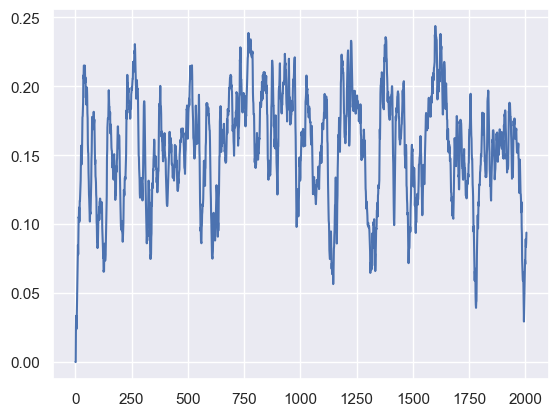

In [3]:
rwg.plot()

# 2. Изотропное упрочнение

*Здесь и далее все материальные функции и параметры взяты из работы ТЕОРИИ ПЛАСТИЧНОСТИ ПРИ СЛОЖНОМ НАГРУЖЕНИИ 
ПО ПЛОСКИМ ТРАЕКТОРИЯМ ДЕФОРМАЦИЙ, В.С. Бондарь, Д.Р. Абашев, Д.Ю. Фомин, 2021, ВЕСТНИК ПНИПУ. МЕХАНИКА, №3


In [209]:
import tqdm
from tqdm.auto import tqdm as tqdm
class IsotropicUniaxial(object):
    def __init__(self, E, nu, C: callable, sigma_s):
        self.E = E
        self.nu = nu
        self.C = C
        self.sigma_s=sigma_s
        self.current_c = C(0)# + sigma_s
        self.cumulative_plast = 0
        # self.point_0 = sigma_s/self.E
        # self.expected_stress_prev = 0

    def __step__(self, strain):
        if np.abs(E*strain) > self.current_c:
            strain_el = self.current_c/self.E
            strain_pl = strain - strain_el
            # self.point_0 = strain
        else:
            # stress = self.current_c - (self.point_0 - strain)*self.E
            strain_pl = 0
            strain_el = strain
            return self.E*strain
        
        self.cumulative_plast+=np.abs(strain_pl)[0]#/self.dt
        strain_pl_ = np.sqrt(2/3)*np.abs(np.abs(strain_pl)[0])#/self.dt
        self.current_c = max(self.C(strain_pl_), self.current_c)# + sigma_s
        
        return self.current_c*np.sign(strain)
    
    def process_sequence(self, sequence_strain):
        stresses = []
        c_s = []
        cumulative_plust = []
        #for strain in tqdm(sequence_strain):
        for strain in sequence_strain:
            stress = self.__step__(strain)
            stresses.append(stress)
            c_s.append(self.current_c)
            cumulative_plust.append(self.cumulative_plast)
            
        return stresses, c_s, cumulative_plust

In [238]:
class IsotropicHardening:
    def __init__(self, E: float, initial_yield_stress: float, C: callable):
        self.E = E
        self.initial_yield_stress = initial_yield_stress
        self.C = C
        self.current_yield_stress = initial_yield_stress
        self.current_odkvist_parameter = 0.
        
        self.odkv_hist = [self.current_odkvist_parameter]
        self.c_s = [initial_yield_stress]

    def predict(self, strain: np.array) -> np.array:
        stress = np.zeros_like(strain)
        for i, strain_i in enumerate(strain):
            if i == 0:
                stress[i] = self.E * strain_i if self.E * strain_i<self.current_yield_stress else self.current_yield_stress
            else:
                d_strain = strain_i - strain[i - 1]
                d_plastic_strain = d_strain if abs(d_strain) > self.current_yield_stress / self.E else 0.
                d_elastic_strain = d_strain - d_plastic_strain
                self.current_odkvist_parameter += d_plastic_strain #self.C(self.current_odkvist_parameter) * d_plastic_strain
                self.odkv_hist.append(self.current_odkvist_parameter)
                self.current_yield_stress = self.initial_yield_stress + self.C(np.sqrt(2/3)*self.current_odkvist_parameter)# * self.current_odkvist_parameter
                self.c_s.append(self.current_yield_stress)
                stress[i] = self.E * d_elastic_strain + self.current_yield_stress
        return stress, self.c_s, self.odkv_hist

## 2.1 Нагружение

In [239]:
def generate_deformation_trajectory(num_steps, start_deformation, max_deformation):
    """
    Generate deformation trajectory for uniaxial loading process with equal time steps.
    """
    deformation = np.linspace(start_deformation, max_deformation, num_steps)
    return deformation

In [240]:
n_point=1000
loading = generate_deformation_trajectory(n_point, 0.0, 0.01)

In [241]:
C_table_x, C_table_y = [0, 16e-5, 61e-5, 11e-4, 21e-4, 48e-4, 71e-4, 1e-2, 1e-1], [62, 144, 204, 228, 256, 295, 335, 350, 800]
C = lambda x: np.interp(x, C_table_x, C_table_y)
E=2e5
nu=0.3
sigma_s = 240

iso = IsotropicHardening(E, sigma_s, C)#IsotropicUniaxial(E, nu, C, sigma_s)

In [242]:
stresses, c_s, cum_plast = iso.predict(loading)#process_sequence(loading.reshape(-1, 1))

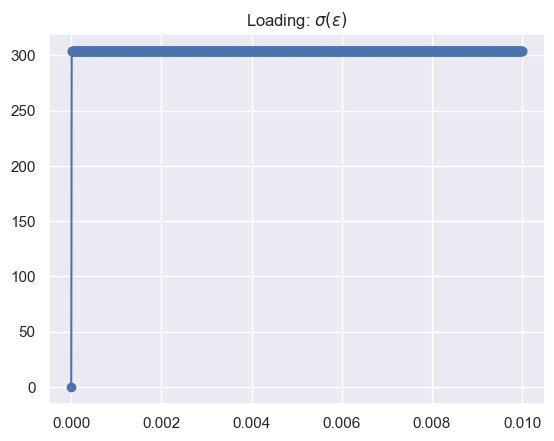

In [243]:
plt.title(r'Loading: $\sigma(\epsilon)$')
plt.plot(loading, stresses)
plt.scatter(loading, stresses)

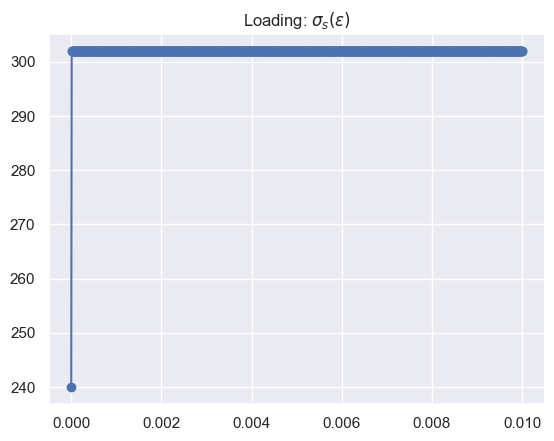

In [244]:
plt.title(r'Loading: $\sigma_s(\epsilon)$')
plt.plot(loading, c_s)
plt.scatter(loading, c_s)

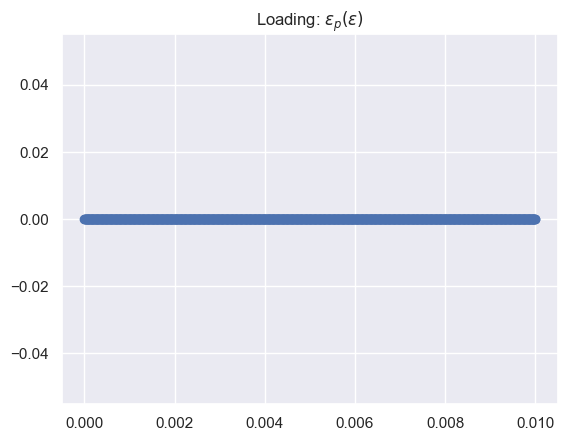

In [245]:
plt.title(r'Loading: $\epsilon_p(\epsilon)$')
plt.plot(loading, cum_plast)
plt.scatter(loading, cum_plast)

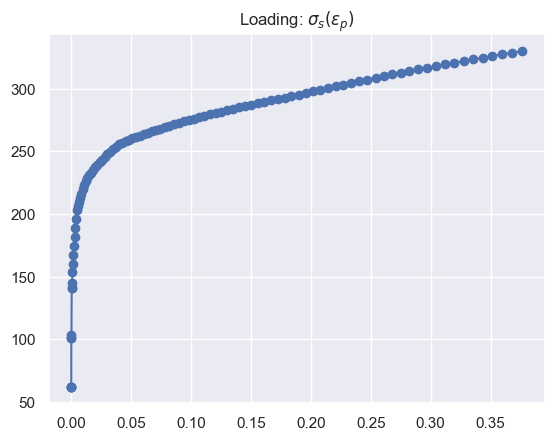

In [179]:
plt.title(r'Loading: $\sigma_s(\epsilon_p)$')
plt.plot(np.array(cum_plast), c_s)
plt.scatter(cum_plast, c_s)

## 2.1 Нагружение + разгрузка

In [74]:
n_point=200
unloading = generate_deformation_trajectory(n_point, 0.3, -0.3)

In [75]:
C_table_x, C_table_y = [0, 16e-5, 61e-5, 11e-4, 21e-4, 48e-4, 71e-4, 1e-2, 1e-1], [62, 144, 204, 228, 256, 295, 335, 350, 800]
C = lambda x: np.interp(x, C_table_x, C_table_y)
E=2e5
nu=0.3

iso = IsotropicUniaxial(E, nu, C, 300)

In [76]:
stresses, c_s, cum_plast = iso.process_sequence(np.concatenate([loading.reshape(-1, 1), unloading.reshape(-1, 1)], axis=0))

In [78]:
x = np.concatenate([loading.reshape(-1, 1), unloading.reshape(-1, 1)], axis=0)

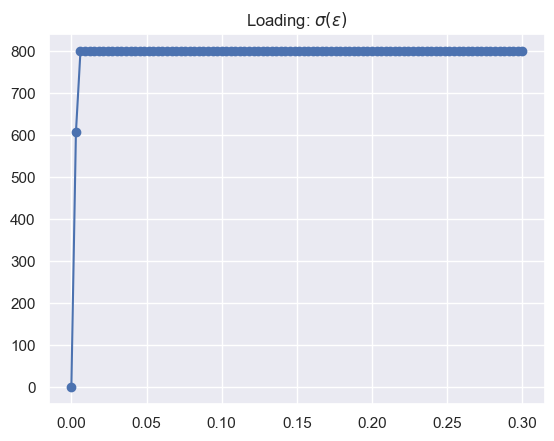

In [82]:
plt.title(r'Loading: $\sigma(\epsilon)$')
plt.plot(x[100:], stresses[100:])
plt.scatter(x[100:], stresses[100:])

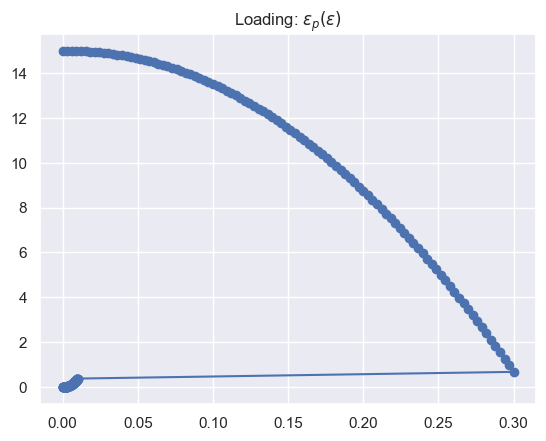

In [81]:
plt.title(r'Loading: $\epsilon_p(\epsilon)$')
plt.plot(x, cum_plast)
plt.scatter(x, cum_plast)

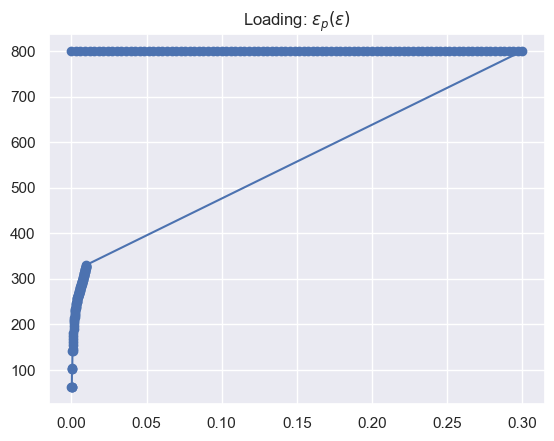

In [86]:
plt.title(r'Loading: $\epsilon_p(\epsilon)$')
plt.plot(x, c_s)
plt.scatter(x, c_s)

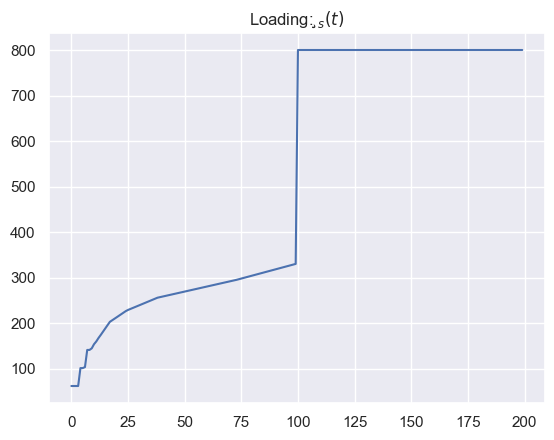

In [89]:
plt.title(r'Loading: $\c_s(t)$')
plt.plot(c_s)
# plt.scatter(c_s)

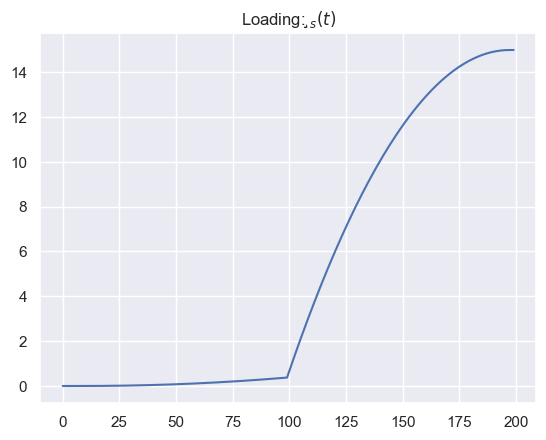

In [90]:
plt.title(r'Loading: $\c_s(t)$')
plt.plot(cum_plast)
# plt.scatter(c_s)

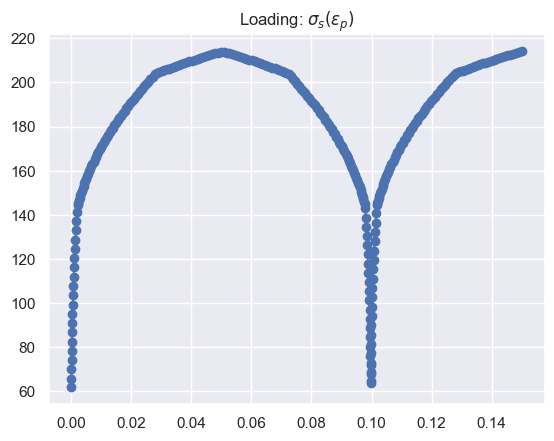

In [84]:
plt.title(r'Loading: $\sigma_s(\epsilon_p)$')
plt.plot(np.array(cum_plast), c_s)
plt.scatter(cum_plast, c_s)

In [5]:
C_table_x, C_table_y = [0, 16e-5, 61e-5, 11e-4, 21e-4, 48e-4, 71e-4, 1e-2, 1e-1], [62, 144, 204, 228, 256, 295, 335, 350, 800]
C = lambda x: np.interp(x, C_table_x, C_table_y)
E=2e5
nu=0.3

iso = IsotropicUniaxial(E, nu, C)

In [6]:
rwg = RandomWalkGenerator(2000, True, 0.01)

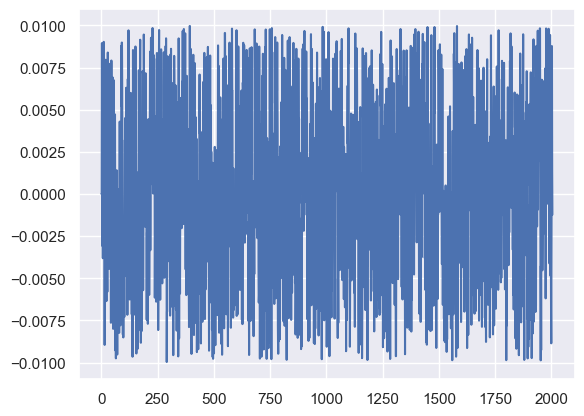

In [7]:
rwg.plot()

In [8]:
sequence = rwg.points

In [106]:
eps_cyclic = np.concatenate([np.linspace(0, 0.01, 20), np.linspace(0.01, 0, 20)])
sequence_1 = eps_cyclic

In [107]:
sequence_1

array([0.        , 0.00052632, 0.00105263, 0.00157895, 0.00210526,
       0.00263158, 0.00315789, 0.00368421, 0.00421053, 0.00473684,
       0.00526316, 0.00578947, 0.00631579, 0.00684211, 0.00736842,
       0.00789474, 0.00842105, 0.00894737, 0.00947368, 0.01      ,
       0.01      , 0.00947368, 0.00894737, 0.00842105, 0.00789474,
       0.00736842, 0.00684211, 0.00631579, 0.00578947, 0.00526316,
       0.00473684, 0.00421053, 0.00368421, 0.00315789, 0.00263158,
       0.00210526, 0.00157895, 0.00105263, 0.00052632, 0.        ])

In [99]:
sequence

array([[ 0.        ],
       [ 0.        ],
       [ 0.0057414 ],
       [ 0.0032607 ],
       [ 0.00661585],
       [ 0.00905474],
       [ 0.00076777],
       [ 0.00303599],
       [-0.00059969],
       [-0.00507485],
       [ 0.00482088],
       [ 0.00192803]])

In [108]:
stresses, c_s, cum_plast = iso.process_sequence(sequence_1.reshape(-1, 1))

In [9]:
stresses, c_s, cum_plast = iso.process_sequence(sequence/5)

In [105]:
E

200000.0

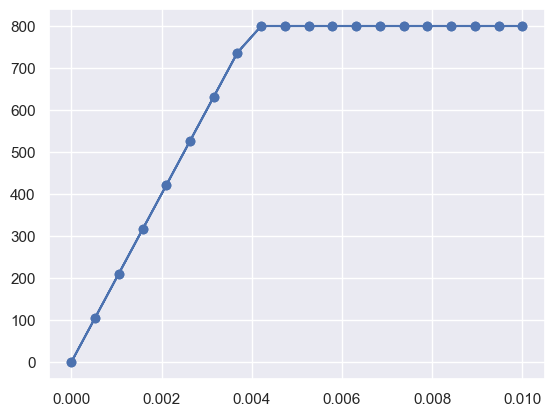

In [109]:
plt.plot(sequence_1, stresses)
plt.scatter(sequence_1, stresses)

In [104]:
stresses

[array([0.]),
 array([295.38523898]),
 array([361.05473452]),
 array([418.14499201]),
 array([495.55665162]),
 array([592.87490447]),
 array([709.69340894]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([800.]),
 array([0.])]

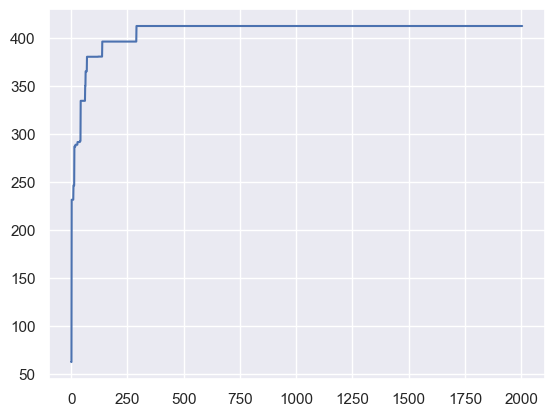

In [11]:
plt.plot(c_s)

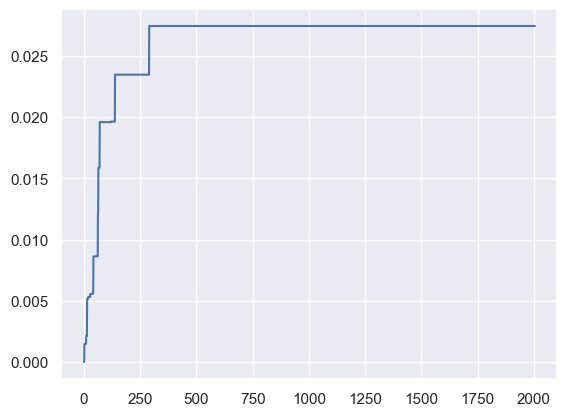

In [12]:
plt.plot(cum_plast)

# 3. Generate dataset

In [13]:
import torch
def get_dataset_isotropic(N, L, C_table_x, C_table_y):
    Stress = []
    Strain = []
    for i in tqdm(range(N)):
        C = lambda x: np.interp(x, C_table_x, C_table_y)
        E=2e5
        nu=0.3

        iso = IsotropicUniaxial(E, nu, C)
        rwg = RandomWalkGenerator(L, True, 0.01)
        sequence = rwg.points
        stresses, c_s, cum_plast = iso.process_sequence(sequence/5)
        Stress.append(np.concatenate(stresses)[:L])
        Strain.append((np.concatenate(sequence)/5)[:L])
    X = torch.Tensor(np.stack(Strain, axis=1))
    Y = torch.Tensor(np.stack(Stress, axis=1))
    return X, Y

In [14]:
    Stress = []
    Strain = []
    for i in tqdm(range(20)):
        C = lambda x: np.interp(x, C_table_x, C_table_y)
        E=2e5
        nu=0.3

        iso = IsotropicUniaxial(E, nu, C)
        rwg = RandomWalkGenerator(10, True, 0.01)
        sequence = rwg.points
        stresses, c_s, cum_plast = iso.process_sequence(sequence/5)
        Stress.append(np.concatenate(stresses)[:10])
        Strain.append((np.concatenate(sequence)/5)[:10])

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
X, Y = get_dataset_isotropic(20, 10, C_table_x, C_table_y)

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
X.shape

torch.Size([10, 20])

In [17]:
Y.shape

torch.Size([10, 20])

In [18]:
X, Y = get_dataset_isotropic(32000, 2000, C_table_x, C_table_y)

  0%|          | 0/32000 [00:00<?, ?it/s]

In [19]:
import numpy as np

np.save('X_32000_iso.csv', X.numpy())
np.save('Y_32000_iso.csv', Y.numpy())

## 4. NN to approximate it

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class CustomDataset(Dataset):
    def __init__(self, X, y, preprocessing=None):
        self.X = X
        self.y = y
        
        if preprocessing:
            self.X, self.y = preprocessing(self.X, self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
import wandb

def init_wandb(project, name):
    WANDB_API = '028f2bb73f8d6aa6ae54ccfb3d22b397309bbdd0'
    wandb.init(project=project, name=name)

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        wandb.log({'train/loss': train_loss}, step=epoch)
        
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item() * inputs.size(0)
            valid_loss /= len(valid_loader.dataset)
            wandb.log({'val/loss': valid_loss}, step=epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

def preprocess_data(X, y):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X = (X - X_mean) / X_std
    return X, y

In [51]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X.T[:, :, None], Y.T, test_size=0.2, shuffle=True, random_state=42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=42) 

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = (X_train - X_mean) / X_std
x_val = (x_val - X_mean) / X_std
x_test = (x_test - X_mean) / X_std

dataset_train = CustomDataset(X_train, y_train)
dataset_test = CustomDataset(x_test, y_test)
dataset_val = CustomDataset(x_val, y_val)

dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [52]:
for b in dataloader_train:
    batch = b

In [53]:
batch[0].shape

torch.Size([32, 2000, 1])

In [54]:
model = LSTMRegressor(1, 128, 2, 1)

In [33]:
init_wandb('LSTM4Plasticity', 'Experiment1')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s_artamonov. Use `wandb login --relogin` to force relogin


In [55]:
criterion = nn.MSELoss()
Adam = torch.optim.Adam(model.parameters(), lr=1e-3)

In [56]:
train_model(model, dataloader_train, dataloader_val, criterion, Adam, 40)

C:\Users\Sergei\anaconda3\envs\plasticity\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32, 2000])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

**Обучение модели:** 

https://colab.research.google.com/drive/1QehUIDbU1gGrrvs2LhKzDNK6I24pVSYZ#scrollTo=tj_mv85GXbp5

https://wandb.ai/s_artamonov/LSTM4Plasticity/runs/wp1jspab?workspace=user-s_artamonov

In [57]:
batch[1].shape

torch.Size([32, 2000])

# 0 -> eps_0 -> 0

In [59]:
model = torch.load('./models/isotropic_model.pth', map_location=torch.device('cpu'))

In [83]:
eps_cyclic = np.concatenate([np.linspace(0, 0.1, 20), np.linspace(0.1, 0, 20)])

In [84]:
eps_cyclic

array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
       0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
       0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ,
       0.1       , 0.09473684, 0.08947368, 0.08421053, 0.07894737,
       0.07368421, 0.06842105, 0.06315789, 0.05789474, 0.05263158,
       0.04736842, 0.04210526, 0.03684211, 0.03157895, 0.02631579,
       0.02105263, 0.01578947, 0.01052632, 0.00526316, 0.        ])

In [91]:
y_pred

tensor([[ 1.0172],
        [65.6588],
        [54.4714],
        [48.9530],
        [44.3685],
        [40.4842],
        [37.3705],
        [34.9563],
        [33.1061],
        [31.6937],
        [30.6208],
        [29.8136],
        [29.2172],
        [28.7901],
        [28.5001],
        [28.3224],
        [28.2373],
        [28.2296],
        [28.2872],
        [28.4010],
        [28.4010],
        [28.2872],
        [28.2296],
        [28.2373],
        [28.3224],
        [28.5001],
        [28.7901],
        [29.2172],
        [29.8136],
        [30.6208],
        [31.6937],
        [33.1061],
        [34.9563],
        [37.3705],
        [40.4842],
        [44.3685],
        [48.9530],
        [54.4714],
        [65.6588],
        [ 1.0172]])

In [85]:
x = torch.tensor(eps_cyclic)[:, None, None]

In [86]:
model.eval()

LSTMRegressor(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [87]:
with torch.no_grad():
    y_pred = model(x.float())

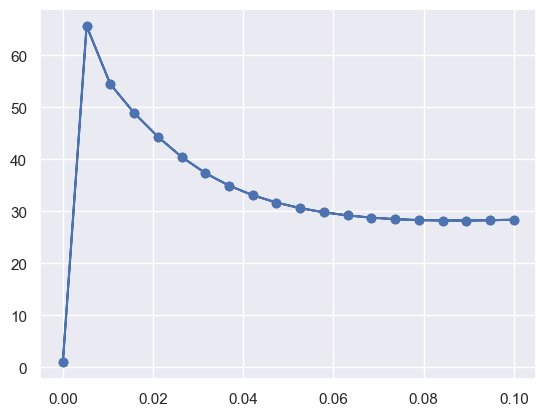

In [88]:
from matplotlib import pyplot as plt

plt.plot(x.squeeze(), y_pred.squeeze())
plt.scatter(x.squeeze(), y_pred.squeeze())

# План

1. Добиться правильной формы на выходе model -> упругая нагрузка, упругая разгрузка. Мы в упругости(?) Проверить размерности(?) Проверить масштаб(?)
2. Упругость - пластичность. + Упругая разгрузка + Упругая разгрузка и вторичная пластичность

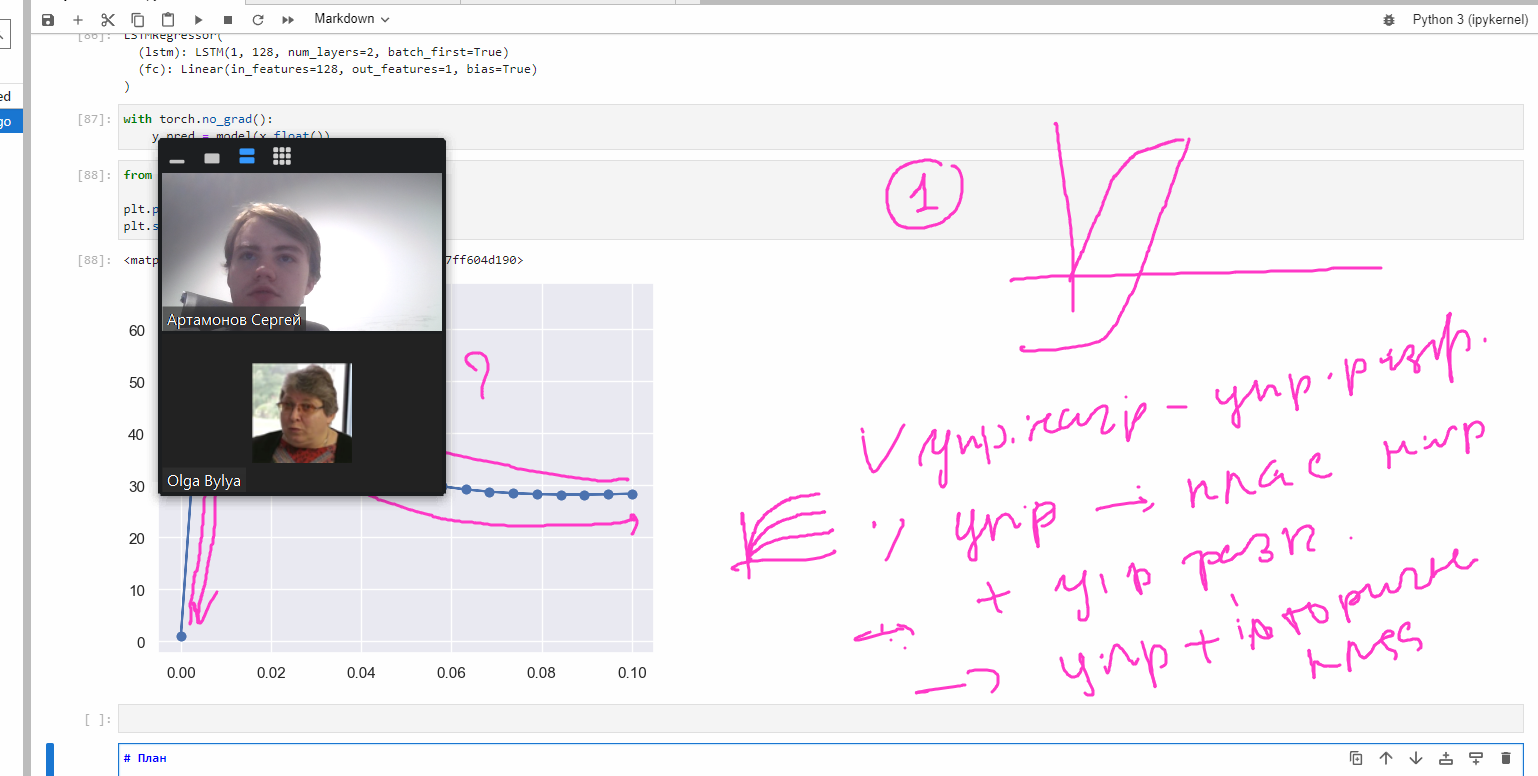

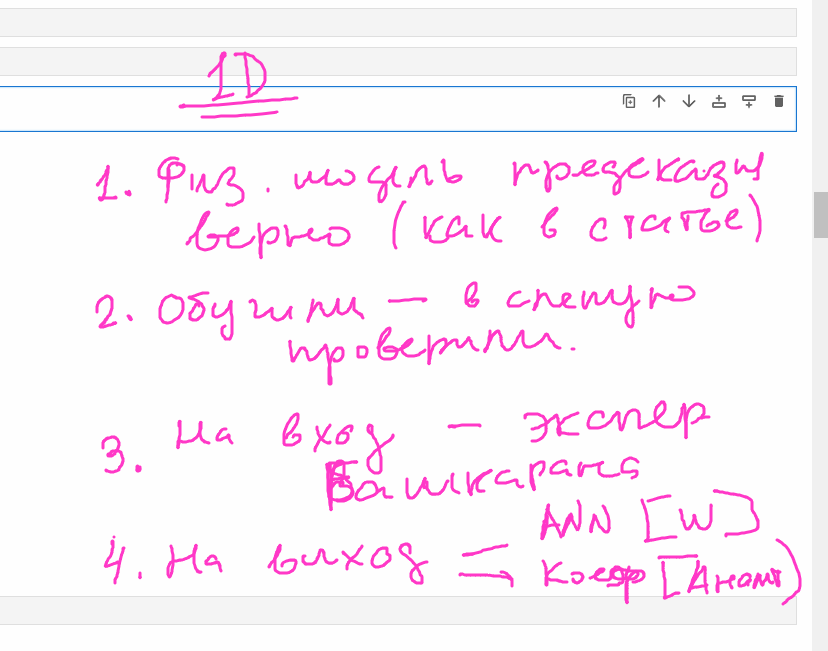

# + Transfer Learning

# Bondars model

In [ ]:
class BondarUniaxial():
    